## 1. 실시간 데이터를 DB로부터 가져오기

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import *

conf = SparkConf()\
        .setAppName('spark-sql')\
        .set('spark.driver.extraClassPath', './data/mysql-connector-java-8.0.26.jar')

sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)
spark = sqlContext.sparkSession

In [2]:
# MySQL로부터 테이블 호출
realtime_traffic = spark.read.format('jdbc')\
        .option('driver', 'com.mysql.jdbc.Driver')\
        .option('url', 'jdbc:mysql://{}:3306/{}'.format('3.37.159.174', 'finalPJT'))\
        .option('user', 'mulcam')\
        .option('password', 'mulcam')\
        .option('dbtable', 'realtime_traffic')\
        .load()

# spark에서 SQL 쿼리를 위해 테이블 선언
realtime_traffic.createOrReplaceTempView('realtime_traffic')

In [3]:
realtime_traffic = realtime_traffic.sort(['baseDate','baseTime'])

In [4]:
d = spark.sql("SELECT baseDate, baseTime, vol, spot_name FROM realtime_traffic ORDER BY baseDate, baseTime")

In [5]:
d = d.select("*").toPandas()
d

,baseDate,baseTime,vol,spot_name
0,20211001,00,534,율곡로(안국역)
1,20211001,00,368,종로(종로3가역)
2,20211001,00,424,세종대로(시청역2)
3,20211001,00,642,종로(동묘앞역)
4,20211001,00,0,대학로(한국방송통신대학교)
...,...,...,...,...
685,20211006,17,1372,종로(동묘앞역)
686,20211006,17,1902,세종대로(시청역2)
687,20211006,17,922,대학로(한국방송통신대학교)
688,20211006,17,1513,율곡로(안국역)


In [6]:
d = d.astype({'vol':'float'})

In [7]:
# 교통량 빈값 평균값으로 처리
for idx, val in d.iterrows():
    if val['vol'] == 0:
        d__ = d.groupby(['spot_name']).mean()
        d['vol'][idx] = np.round_(d__['vol'][0])

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
d

,baseDate,baseTime,vol,spot_name
0,20211001,00,534.0,율곡로(안국역)
1,20211001,00,368.0,종로(종로3가역)
2,20211001,00,424.0,세종대로(시청역2)
3,20211001,00,642.0,종로(동묘앞역)
4,20211001,00,200.0,대학로(한국방송통신대학교)
...,...,...,...,...
685,20211006,17,1372.0,종로(동묘앞역)
686,20211006,17,1902.0,세종대로(시청역2)
687,20211006,17,922.0,대학로(한국방송통신대학교)
688,20211006,17,1513.0,율곡로(안국역)


In [9]:
d['년도'] = ''
d['월'] = ''
d['일'] = ''

for idx, val in d.iterrows():
    d['년도'][idx] = d['baseDate'][idx][:4]
    d['월'][idx] = d['baseDate'][idx][4:6]
    d['일'][idx] = d['baseDate'][idx][6:]

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
d['ds'] = d['년도'].apply(str)+'-' + d['월'].apply(str)+'-'  + d['일'].apply(str)+'-' + d['baseTime'].apply(str)
d['ds'] = pd.to_datetime(d['ds'],format='%Y-%m-%d-%H')

In [11]:
accident_list = ['안국역사거리', '광하문우체국사거리','종로3가역사거리', '이화사거리', '동묘앞역사거리']
traffic_list = ['율곡로(안국역)', '세종대로(시청역2)', '종로(종로3가역)', '대학로(한국방송통신대학교)', '종로(동묘앞역)']

data = {}
for i in range(len(accident_list)):
    data[traffic_list[i]] = accident_list[i]

d['사고다발지점'] = ''
for idx, val in d.iterrows():
    d['사고다발지점'][idx] = data[val['spot_name']]

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [12]:
d['요일'] = np.nan
d = d.rename(columns={'vol':'y', 'baseTime':'시간', 'spot_name':'교통량측정지점명'})
d = d[['년도','월','일','요일','시간','교통량측정지점명','사고다발지점','y','ds']]

In [13]:
d

,년도,월,일,요일,시간,교통량측정지점명,사고다발지점,y,ds
0,2021,10,01,NaN,00,율곡로(안국역),안국역사거리,534.0,2021-10-01 00:00:00
1,2021,10,01,NaN,00,종로(종로3가역),종로3가역사거리,368.0,2021-10-01 00:00:00
2,2021,10,01,NaN,00,세종대로(시청역2),광하문우체국사거리,424.0,2021-10-01 00:00:00
3,2021,10,01,NaN,00,종로(동묘앞역),동묘앞역사거리,642.0,2021-10-01 00:00:00
4,2021,10,01,NaN,00,대학로(한국방송통신대학교),이화사거리,200.0,2021-10-01 00:00:00
...,...,...,...,...,...,...,...,...,...
685,2021,10,06,NaN,17,종로(동묘앞역),동묘앞역사거리,1372.0,2021-10-06 17:00:00
686,2021,10,06,NaN,17,세종대로(시청역2),광하문우체국사거리,1902.0,2021-10-06 17:00:00
687,2021,10,06,NaN,17,대학로(한국방송통신대학교),이화사거리,922.0,2021-10-06 17:00:00
688,2021,10,06,NaN,17,율곡로(안국역),안국역사거리,1513.0,2021-10-06 17:00:00


In [14]:
d = pd.concat([d.query('ds.dt.dayofweek == 0').fillna('월'), d.query('ds.dt.dayofweek == 1').fillna('화'), d.query('ds.dt.dayofweek == 2').fillna('수'), d.query('ds.dt.dayofweek == 3').fillna('목'), d.query('ds.dt.dayofweek == 4').fillna('금'), d.query('ds.dt.dayofweek == 5').fillna('토'), d.query('ds.dt.dayofweek == 6').fillna('일')])

In [15]:
d = d.sort_values(['년도','월','일','시간'])

In [16]:
d

,년도,월,일,요일,시간,교통량측정지점명,사고다발지점,y,ds
0,2021,10,01,금,00,율곡로(안국역),안국역사거리,534.0,2021-10-01 00:00:00
1,2021,10,01,금,00,종로(종로3가역),종로3가역사거리,368.0,2021-10-01 00:00:00
2,2021,10,01,금,00,세종대로(시청역2),광하문우체국사거리,424.0,2021-10-01 00:00:00
3,2021,10,01,금,00,종로(동묘앞역),동묘앞역사거리,642.0,2021-10-01 00:00:00
4,2021,10,01,금,00,대학로(한국방송통신대학교),이화사거리,200.0,2021-10-01 00:00:00
...,...,...,...,...,...,...,...,...,...
685,2021,10,06,수,17,종로(동묘앞역),동묘앞역사거리,1372.0,2021-10-06 17:00:00
686,2021,10,06,수,17,세종대로(시청역2),광하문우체국사거리,1902.0,2021-10-06 17:00:00
687,2021,10,06,수,17,대학로(한국방송통신대학교),이화사거리,922.0,2021-10-06 17:00:00
688,2021,10,06,수,17,율곡로(안국역),안국역사거리,1513.0,2021-10-06 17:00:00


## 2. 2020년~2021/09/30 데이터 만들기

#### 교통량(2017~2021_9).csv 로부터 2020년도만 가져와서 결측치 처리하기

In [17]:
df = pd.read_csv('./교통량(2017~2021_9).csv', encoding='utf-8')

In [18]:
df = df[(df['년도']==2020) | (df['년도']==2021)]
df

,년도,월,일,요일,시간,교통량측정지점명,사고다발지점,교통량
131400,2020,1,1,수,0,대학로(한국방송통신대학교),이화사거리,805.0
131401,2020,1,1,수,1,대학로(한국방송통신대학교),이화사거리,605.0
131402,2020,1,1,수,2,대학로(한국방송통신대학교),이화사거리,452.0
131403,2020,1,1,수,3,대학로(한국방송통신대학교),이화사거리,375.0
131404,2020,1,1,수,4,대학로(한국방송통신대학교),이화사거리,432.0
...,...,...,...,...,...,...,...,...
208075,2021,9,30,NaN,19,종로(종로3가역),종로3가역사거리,1031.0
208076,2021,9,30,NaN,20,종로(종로3가역),종로3가역사거리,949.0
208077,2021,9,30,NaN,21,종로(종로3가역),종로3가역사거리,811.0
208078,2021,9,30,NaN,22,종로(종로3가역),종로3가역사거리,642.0


In [20]:
# ds(일시, datetime 시계열) 열 만들기
df['ds'] = df['년도'].apply(str)+'-' + df['월'].apply(str)+'-'  + df['일'].apply(str)+'-' + df['시간'].apply(str)
df['ds'] = pd.to_datetime(df['ds'],format='%Y-%m-%d-%H')

# 행,열 이름 바꾸기
df.rename(columns={'교통량':'y'},inplace=True)

In [21]:
# 요일 결측치 처리
df = pd.concat([df.query('ds.dt.dayofweek == 0').fillna('월'), df.query('ds.dt.dayofweek == 1').fillna('화'), df.query('ds.dt.dayofweek == 2').fillna('수'), df.query('ds.dt.dayofweek == 3').fillna('목'), df.query('ds.dt.dayofweek == 4').fillna('금'), df.query('ds.dt.dayofweek == 5').fillna('토'), df.query('ds.dt.dayofweek == 6').fillna('일')])

In [22]:
df_1 = df[df['사고다발지점']=='이화사거리']
df_2 = df[df['사고다발지점']=='광하문우체국사거리']
df_3 = df[df['사고다발지점']=='안국역사거리']
df_4 = df[df['사고다발지점']=='동묘앞역사거리']
df_5 = df[df['사고다발지점']=='종로3가역사거리']

In [23]:
# df_1 교통량 결측치 처리

df_1 = df_1.sort_values(['년도','월','일','시간'])

df_mean = df_1.groupby(['년도','월','요일','시간']).median()
df_mean = df_mean.reset_index()

df_su = df_mean[(df_mean['년도']==2021) & (df_mean['월']==9) & (df_mean['요일']=='수')]
df_mok = df_mean[(df_mean['년도']==2021) & (df_mean['월']==9) & (df_mean['요일']=='목')]
df_temp = df_1[(df_1['월'] == 9) & (df_1['년도']==2021) & (df_1['y']==0.0)]


for idx, val in df_temp.iterrows():
    if val['y'] == 0 and val['요일'] == '수':
        time = df_temp.loc[idx]['시간']
        i = df_su.index[df_su['시간'] == time].tolist()
        
        df_temp['y'][idx] = df_su['y'][i[0]]
        
    if val['y'] == 0 and val['요일'] == '목':
        time_2 = df_temp.loc[idx]['시간']
        i_2 = df_mok.index[df_mok['시간'] == time_2].tolist()
        
        df_temp['y'][idx] = df_mok['y'][i_2[0]]
        
        
df_temp = df_temp.reset_index(drop=True)

df_1 = pd.concat([df_1, df_temp])

delete_idx = df_1.index[df_1['y'] == 0.0].tolist()
df_1 = df_1.drop(delete_idx)

df_1 = df_1.sort_values(['년도','월','일','시간'])

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [24]:
df_1

,년도,월,일,요일,시간,교통량측정지점명,사고다발지점,y,ds
131400,2020,1,1,수,0,대학로(한국방송통신대학교),이화사거리,805.0,2020-01-01 00:00:00
131401,2020,1,1,수,1,대학로(한국방송통신대학교),이화사거리,605.0,2020-01-01 01:00:00
131402,2020,1,1,수,2,대학로(한국방송통신대학교),이화사거리,452.0,2020-01-01 02:00:00
131403,2020,1,1,수,3,대학로(한국방송통신대학교),이화사거리,375.0,2020-01-01 03:00:00
131404,2020,1,1,수,4,대학로(한국방송통신대학교),이화사거리,432.0,2020-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...
33,2021,9,30,목,19,대학로(한국방송통신대학교),이화사거리,776.0,2021-09-30 19:00:00
34,2021,9,30,목,20,대학로(한국방송통신대학교),이화사거리,732.0,2021-09-30 20:00:00
35,2021,9,30,목,21,대학로(한국방송통신대학교),이화사거리,713.0,2021-09-30 21:00:00
36,2021,9,30,목,22,대학로(한국방송통신대학교),이화사거리,649.0,2021-09-30 22:00:00


In [25]:
final_df = pd.concat([df_1, df_2, df_3, df_4, df_5])
final_df = final_df.sort_values(['년도','월','일','시간'])
final_df

,년도,월,일,요일,시간,교통량측정지점명,사고다발지점,y,ds
131400,2020,1,1,수,0,대학로(한국방송통신대학교),이화사거리,805.0,2020-01-01 00:00:00
131424,2020,1,1,수,0,세종대로(시청역2),광하문우체국사거리,1284.5,2020-01-01 00:00:00
131448,2020,1,1,수,0,율곡로(안국역),안국역사거리,1116.5,2020-01-01 00:00:00
131472,2020,1,1,수,0,종로(동묘앞역),동묘앞역사거리,847.0,2020-01-01 00:00:00
131496,2020,1,1,수,0,종로(종로3가역),종로3가역사거리,512.0,2020-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...
37,2021,9,30,목,23,대학로(한국방송통신대학교),이화사거리,459.0,2021-09-30 23:00:00
208007,2021,9,30,목,23,세종대로(시청역2),광하문우체국사거리,647.0,2021-09-30 23:00:00
208031,2021,9,30,목,23,율곡로(안국역),안국역사거리,753.0,2021-09-30 23:00:00
208055,2021,9,30,목,23,종로(동묘앞역),동묘앞역사거리,786.0,2021-09-30 23:00:00


In [29]:
final_df.to_csv('2020~20210930_교통량데이터.csv', encoding='utf-8-sig', index=False)

## 3. 2020년 ~ 현재 데이터 합치기

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import *

In [2]:
df_before = pd.read_csv('./2020~20210930_교통량데이터.csv', encoding='utf-8')
df_before

,년도,월,일,요일,시간,교통량측정지점명,사고다발지점,y,ds
0,2020,1,1,수,0,대학로(한국방송통신대학교),이화사거리,805.0,2020-01-01 00:00:00
1,2020,1,1,수,0,세종대로(시청역2),광하문우체국사거리,1284.5,2020-01-01 00:00:00
2,2020,1,1,수,0,율곡로(안국역),안국역사거리,1116.5,2020-01-01 00:00:00
3,2020,1,1,수,0,종로(동묘앞역),동묘앞역사거리,847.0,2020-01-01 00:00:00
4,2020,1,1,수,0,종로(종로3가역),종로3가역사거리,512.0,2020-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...
76675,2021,9,30,목,23,대학로(한국방송통신대학교),이화사거리,459.0,2021-09-30 23:00:00
76676,2021,9,30,목,23,세종대로(시청역2),광하문우체국사거리,647.0,2021-09-30 23:00:00
76677,2021,9,30,목,23,율곡로(안국역),안국역사거리,753.0,2021-09-30 23:00:00
76678,2021,9,30,목,23,종로(동묘앞역),동묘앞역사거리,786.0,2021-09-30 23:00:00


In [3]:
# MySQL로부터 테이블 호출
conf = SparkConf()\
        .setAppName('spark-sql')\
        .set('spark.driver.extraClassPath', './data/mysql-connector-java-8.0.26.jar')

sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)
spark = sqlContext.sparkSession

realtime_traffic = spark.read.format('jdbc')\
        .option('driver', 'com.mysql.jdbc.Driver')\
        .option('url', 'jdbc:mysql://{}:3306/{}'.format('3.37.159.174', 'finalPJT'))\
        .option('user', 'mulcam')\
        .option('password', 'mulcam')\
        .option('dbtable', 'realtime_traffic')\
        .load()

# spark에서 SQL 쿼리를 위해 테이블 선언
realtime_traffic.createOrReplaceTempView('realtime_traffic')

In [4]:
realtime_traffic = realtime_traffic.sort(['baseDate','baseTime'])

d = spark.sql("SELECT baseDate, baseTime, vol, spot_name FROM realtime_traffic ORDER BY baseDate, baseTime")
d = d.select("*").toPandas()
d = d.astype({'vol':'float'})

# 교통량 빈값 평균값으로 처리
for idx, val in d.iterrows():
    if val['vol'] == 0:
        d__ = d.groupby(['spot_name']).mean()
        d['vol'][idx] = np.round_(d__['vol'][0])
        
# 데이터프레임 합치기 위해 DB에 저장된 데이터의 형태를 변경
d['년도'] = ''
d['월'] = ''
d['일'] = ''

for idx, val in d.iterrows():
    d['년도'][idx] = d['baseDate'][idx][:4]
    d['월'][idx] = d['baseDate'][idx][4:6]
    d['일'][idx] = d['baseDate'][idx][6:]
    
d['ds'] = d['년도'].apply(str)+'-' + d['월'].apply(str)+'-'  + d['일'].apply(str)+'-' + d['baseTime'].apply(str)
d['ds'] = pd.to_datetime(d['ds'],format='%Y-%m-%d-%H')

accident_list = ['안국역사거리', '광하문우체국사거리','종로3가역사거리', '이화사거리', '동묘앞역사거리']
traffic_list = ['율곡로(안국역)', '세종대로(시청역2)', '종로(종로3가역)', '대학로(한국방송통신대학교)', '종로(동묘앞역)']

data = {}
for i in range(len(accident_list)):
    data[traffic_list[i]] = accident_list[i]

d['사고다발지점'] = ''
for idx, val in d.iterrows():
    d['사고다발지점'][idx] = data[val['spot_name']]
    
d['요일'] = np.nan
d = d.rename(columns={'vol':'y', 'baseTime':'시간', 'spot_name':'교통량측정지점명'})
d = d[['년도','월','일','요일','시간','교통량측정지점명','사고다발지점','y','ds']]

d = pd.concat([d.query('ds.dt.dayofweek == 0').fillna('월'), d.query('ds.dt.dayofweek == 1').fillna('화'), d.query('ds.dt.dayofweek == 2').fillna('수'), d.query('ds.dt.dayofweek == 3').fillna('목'), d.query('ds.dt.dayofweek == 4').fillna('금'), d.query('ds.dt.dayofweek == 5').fillna('토'), d.query('ds.dt.dayofweek == 6').fillna('일')])
d = d.sort_values(['년도','월','일','시간'])

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [18]:
traffic_df = pd.concat([df_before, d])
traffic_df

,년도,월,일,요일,시간,교통량측정지점명,사고다발지점,y,ds
0,2020,1,1,수,0,대학로(한국방송통신대학교),이화사거리,805.0,2020-01-01 00:00:00
1,2020,1,1,수,0,세종대로(시청역2),광하문우체국사거리,1284.5,2020-01-01 00:00:00
2,2020,1,1,수,0,율곡로(안국역),안국역사거리,1116.5,2020-01-01 00:00:00
3,2020,1,1,수,0,종로(동묘앞역),동묘앞역사거리,847.0,2020-01-01 00:00:00
4,2020,1,1,수,0,종로(종로3가역),종로3가역사거리,512.0,2020-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...
685,2021,10,06,수,17,종로(동묘앞역),동묘앞역사거리,1372.0,2021-10-06 17:00:00
686,2021,10,06,수,17,세종대로(시청역2),광하문우체국사거리,1902.0,2021-10-06 17:00:00
687,2021,10,06,수,17,대학로(한국방송통신대학교),이화사거리,922.0,2021-10-06 17:00:00
688,2021,10,06,수,17,율곡로(안국역),안국역사거리,1513.0,2021-10-06 17:00:00


In [19]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77370 entries, 0 to 689
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   년도        77370 non-null  object 
 1   월         77370 non-null  object 
 2   일         77370 non-null  object 
 3   요일        77370 non-null  object 
 4   시간        77370 non-null  object 
 5   교통량측정지점명  77370 non-null  object 
 6   사고다발지점    77370 non-null  object 
 7   y         77370 non-null  float64
 8   ds        77370 non-null  object 
dtypes: float64(1), object(8)
memory usage: 5.9+ MB


In [20]:
traffic_df = traffic_df.astype(
                        {'년도':int,
                        '월':int,
                        '일':int,
                        '시간':int})
traffic_df['ds'] = pd.to_datetime(traffic_df['ds'])

In [22]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77370 entries, 0 to 689
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   년도        77370 non-null  int64         
 1   월         77370 non-null  int64         
 2   일         77370 non-null  int64         
 3   요일        77370 non-null  object        
 4   시간        77370 non-null  int64         
 5   교통량측정지점명  77370 non-null  object        
 6   사고다발지점    77370 non-null  object        
 7   y         77370 non-null  float64       
 8   ds        77370 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 5.9+ MB


In [23]:
df_1 = traffic_df[traffic_df['사고다발지점']=='이화사거리']
df_2 = traffic_df[traffic_df['사고다발지점']=='광하문우체국사거리']
df_3 = traffic_df[traffic_df['사고다발지점']=='안국역사거리']
df_4 = traffic_df[traffic_df['사고다발지점']=='동묘앞역사거리']
df_5 = traffic_df[traffic_df['사고다발지점']=='종로3가역사거리']

# 이화사거리

In [34]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle


df_1['cap'] = 2800
df_1['floor'] = 220

day = 1     # 테스트할 일수
x = 90 + day   # 학습할 일수

# 학습/예측에 사용할 데이터
train_df = df_1.iloc[-x*24:-day*24]

# 실제값으로 사용 : 예측한 값과 비교할 값
test_df = df_1.iloc[-day*24:]

# 모델 생성
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
model_fit = prophet.fit(train_df)

# KeyError: 'metric_file'
# pip install pystan --upgrade  
# 아나콘다 프롬트에서

# # y일 예측
# future_data = prophet.make_future_dataframe(periods=day*24, freq='H')
# forecast_data = prophet.predict(future_data)

# pred_y = forecast_data['yhat'].tail(24*day)
# test_y = test_df['y']

349.21078088184703


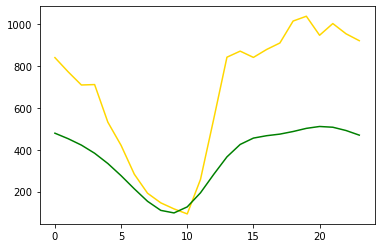

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

plt.plot(test_y.values, color='gold')
plt.plot(pred_y.values, color='green')     # 모델이 예상한  교통량 그래프

In [ ]:
pickle.dump(model_fit, open('이화사거리.pkl', 'wb'))

# 광하문우체국사거리

In [38]:
df_2['cap'] = 2800
df_2['floor'] = 220

day = 1     # 테스트할 일수
x = 90 + day   # 학습할 일수
  
# 학습/예측에 사용할 데이터
train_df = df_2.iloc[-x*24:-day*24]

# 실제값으로 사용 : 예측한 값과 비교할 값
test_df = df_2.iloc[-day*24:]

# 모델 생성
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
model_fit = prophet.fit(train_df)

# KeyError: 'metric_file'
# pip install pystan --upgrade  
# 아나콘다 프롬트에서

# y일 예측
future_data = prophet.make_future_dataframe(periods=day*24, freq='H')
forecast_data = prophet.predict(future_data)

pred_y = forecast_data['yhat'].tail(24*day)
test_y = test_df['y']

354.6722707033118


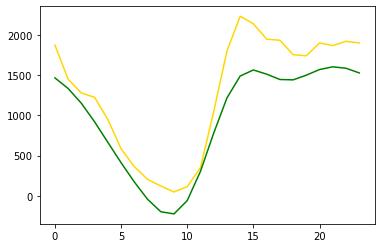

In [39]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

plt.plot(test_y.values, color='gold') 
plt.plot(pred_y.values, color='green')     # 모델이 예상한  교통량 그래프

In [ ]:
pickle.dump(model_fit, open('광하문우체국사거리.pkl', 'wb'))

# 안국역사거리

In [40]:
df_3['cap'] = 2800
df_3['floor'] = 220

day = 1     # 테스트할 일수
# x = 90 + day   # 학습할 일수
  
# 학습/예측에 사용할 데이터
train_df = df_3.iloc[-x*24:-day*24]

# 실제값으로 사용 : 예측한 값과 비교할 값
test_df = df_3.iloc[-day*24:]

# 모델 생성
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
model_fit = prophet.fit(train_df)

# KeyError: 'metric_file'
# pip install pystan --upgrade  
# 아나콘다 프롬트에서

# y일 예측
future_data = prophet.make_future_dataframe(periods=day*24, freq='H')
forecast_data = prophet.predict(future_data)

pred_y = forecast_data['yhat'].tail(24*day)
test_y = test_df['y']

130.9631817878138


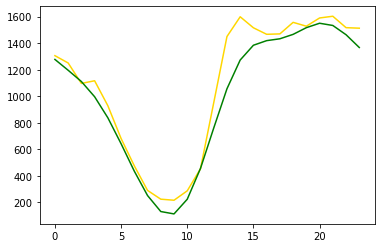

In [41]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

plt.plot(test_y.values, color='gold') 
plt.plot(pred_y.values, color='green')     # 모델이 예상한  교통량 그래프

In [ ]:
pickle.dump(model_fit, open('안국역사거리.pkl', 'wb'))

# 동묘앞역사거리

In [47]:
df_4['cap'] = 2800
df_4['floor'] = 220

day = 1     # 테스트할 일수
# x = 90 + day   # 학습할 일수
  
# 학습/예측에 사용할 데이터
train_df = df_4.iloc[-x*24:-day*24]

# 실제값으로 사용 : 예측한 값과 비교할 값
test_df = df_4.iloc[-day*24:]

# 모델 생성
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
model_fit = prophet.fit(train_df)

# KeyError: 'metric_file'
# pip install pystan --upgrade  
# 아나콘다 프롬트에서

# y일 예측
future_data = prophet.make_future_dataframe(periods=day*24, freq='H')
forecast_data = prophet.predict(future_data)

pred_y = forecast_data['yhat'].tail(24*day)
test_y = test_df['y']

96.78255860993796


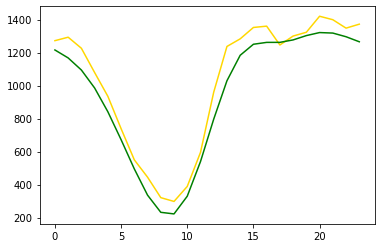

In [48]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

plt.plot(test_y.values, color='gold') 
plt.plot(pred_y.values, color='green')     # 모델이 예상한  교통량 그래프

In [ ]:
pickle.dump(model_fit, open('동묘앞역사거리.pkl', 'wb'))

# 종로3가역사거리

In [49]:
df_5['cap'] = 2800
df_5['floor'] = 220

day = 1     # 테스트할 일수
# x = 90 + day   # 학습할 일수
  
# 학습/예측에 사용할 데이터
train_df = df_5.iloc[-x*24:-day*24]

# 실제값으로 사용 : 예측한 값과 비교할 값
test_df = df_5.iloc[-day*24:]

# 모델 생성
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
model_fit = prophet.fit(train_df)

# KeyError: 'metric_file'
# pip install pystan --upgrade  
# 아나콘다 프롬트에서

# y일 예측
future_data = prophet.make_future_dataframe(periods=day*24, freq='H')
forecast_data = prophet.predict(future_data)

pred_y = forecast_data['yhat'].tail(24*day)
test_y = test_df['y']

110.15142800911542


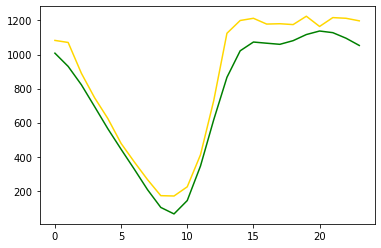

In [50]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

plt.plot(test_y.values, color='gold') 
plt.plot(pred_y.values, color='green')     # 모델이 예상한  교통량 그래프

In [ ]:
pickle.dump(model_fit, open('종로3가역사거리.pkl', 'wb'))